In [41]:
library(Seurat)
library(tidyverse)
library(clusterProfiler)
library(org.Mm.eg.db)
library(DESeq2)
library(pheatmap)
library(SCpubr)



── SCpubr 2.0.2 ────────────────────────────────────────────────────────────────

ℹ Have a look at extensive tutorials in SCpubr's book.

✔ If you use SCpubr in your research, please cite it accordingly.

★ If the package is useful to you, consider leaving a Star in the GitHub repository.

! Keep track of the package updates on Twitter (@Enblacar) or in the Official NEWS website.

♥ Happy plotting!



── Tips! ──

ℹ To remove the white and black end from continuous palettes, use: options("SCpubr.ColorPaletteEnds" = FALSE)

✖ To suppress this startup message, use: suppressPackageStartupMessages(library(SCpubr))
✖ Alternatively, you can also set the following option: options("SCpubr.verbose" = FALSE)
  And then load the package normally (and faster) as: library(SCpubr)

────────────────────────────────────────────────────────────────────────────────


# Entire cells (Fig. A-C)

In [4]:
so <- readRDS("wholePFC_named_final.rds")

#Figure A

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message in plot_theme(plot):
“The `raster` theme element is not defined in the element hierarchy.”


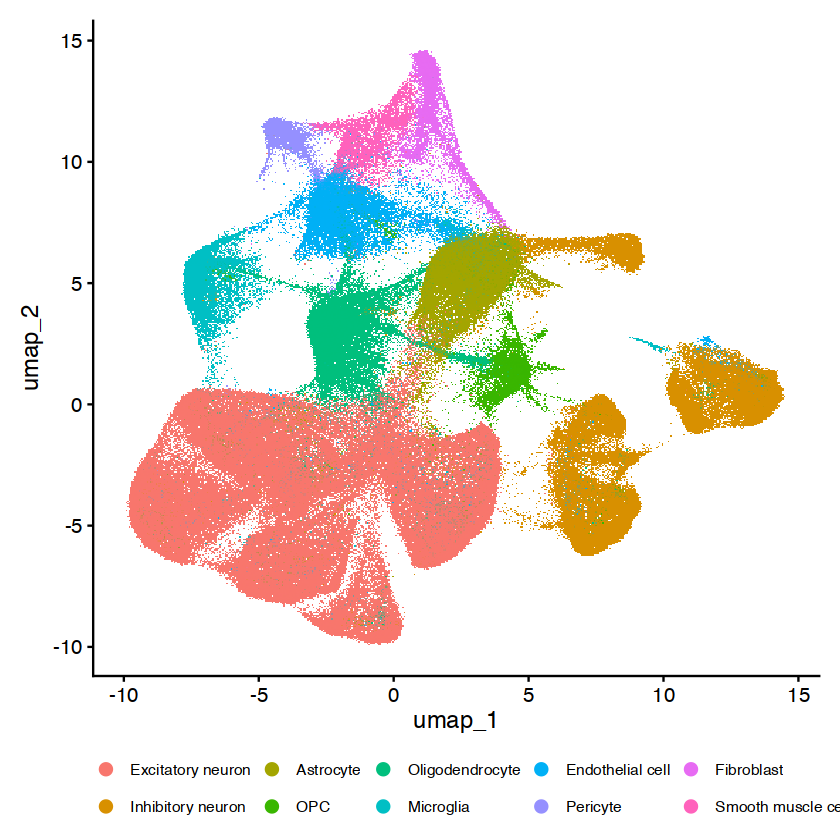

In [6]:
DimPlot(so)+  theme(legend.position = "bottom",legend.text=element_text(size=9),raster =FALSE)

# Figure B

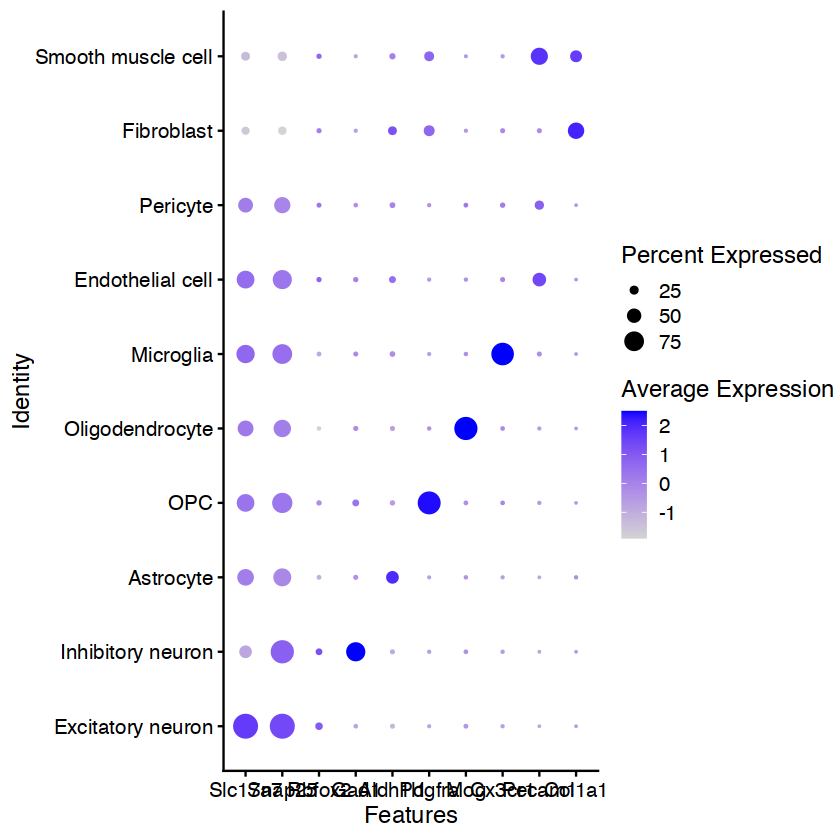

In [7]:
DotPlot(so,features = c("Slc17a7","Snap25","Rbfox2","Gad1","Aldh1l1","Pdgfra","Mog","Cx3cr1","Pecam1","Col1a1") )

# Figure C

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


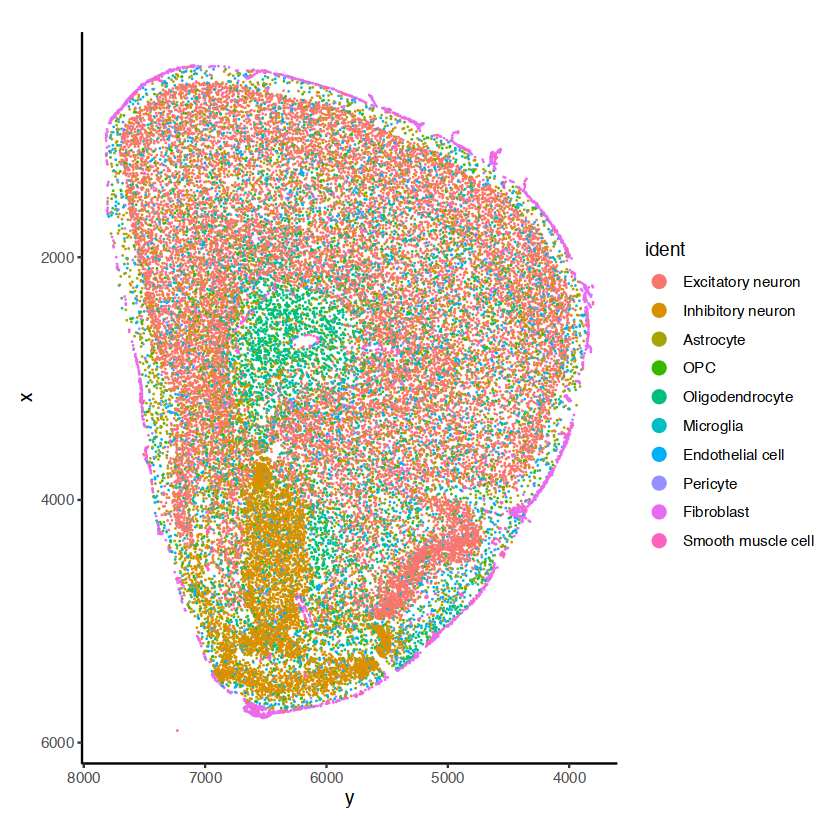

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


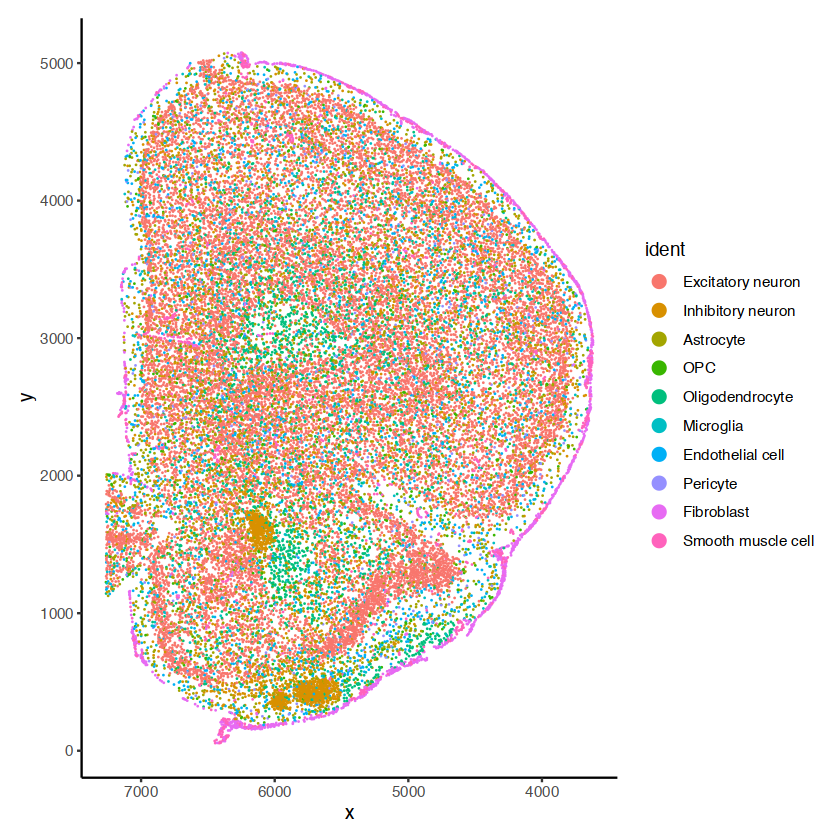

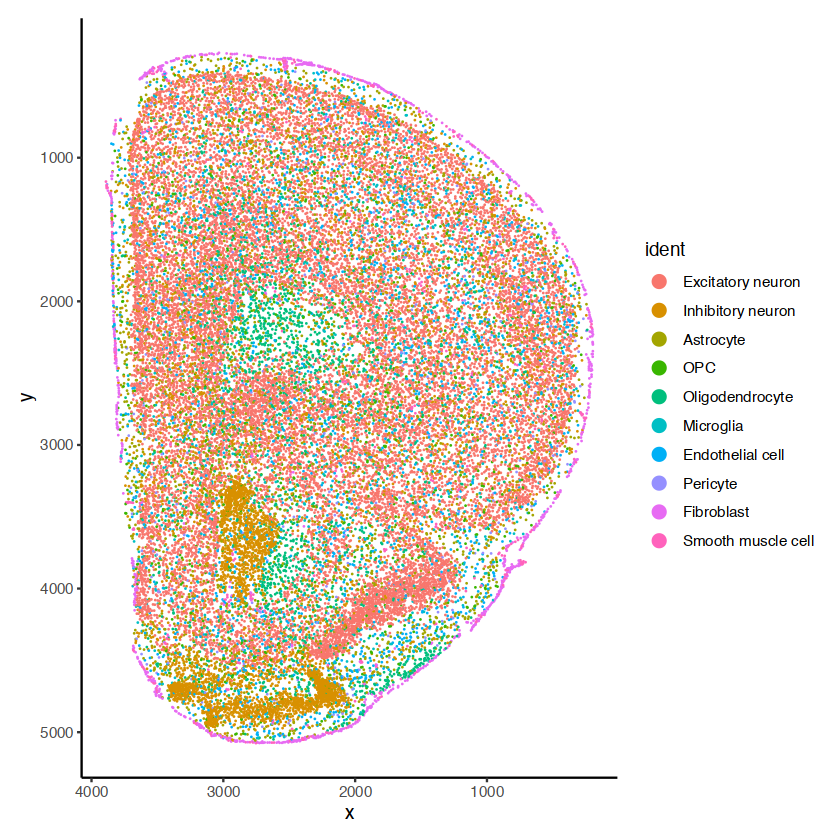

In [13]:
ImageDimPlot(so,fov = "Region_1_full.2",flip_xy = TRUE) +theme_classic()+scale_y_reverse()+scale_x_reverse()
ImageDimPlot(so,fov = "Region_7_full.2",flip_xy = FALSE) +theme_classic()+scale_y_reverse()
ImageDimPlot(so,fov = "Region_5_full",flip_xy = FALSE)+theme_classic() +scale_y_reverse() +scale_x_reverse()

In [9]:
AS <- readRDS("Astrocyte_only.rds")

In [15]:
Idents(AS) <- "seurat_clusters"

# Figure D

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


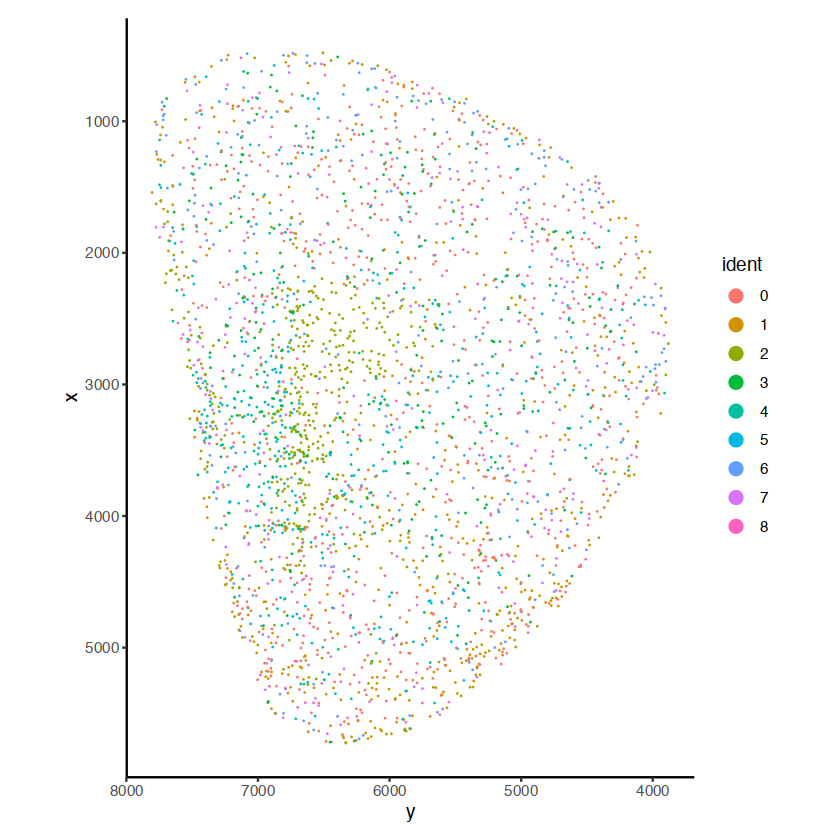

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


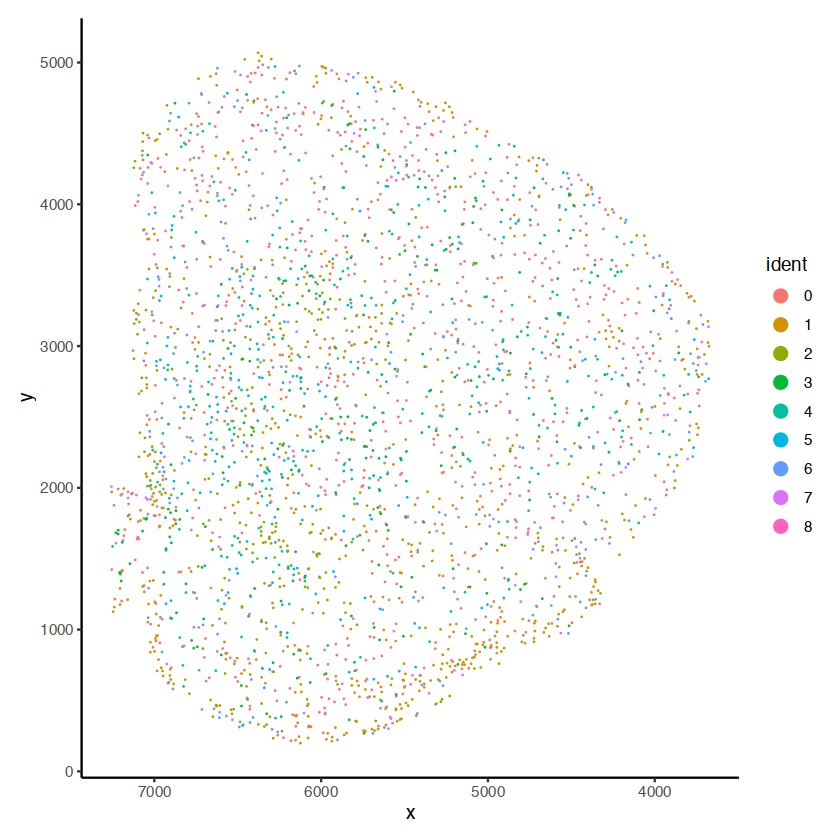

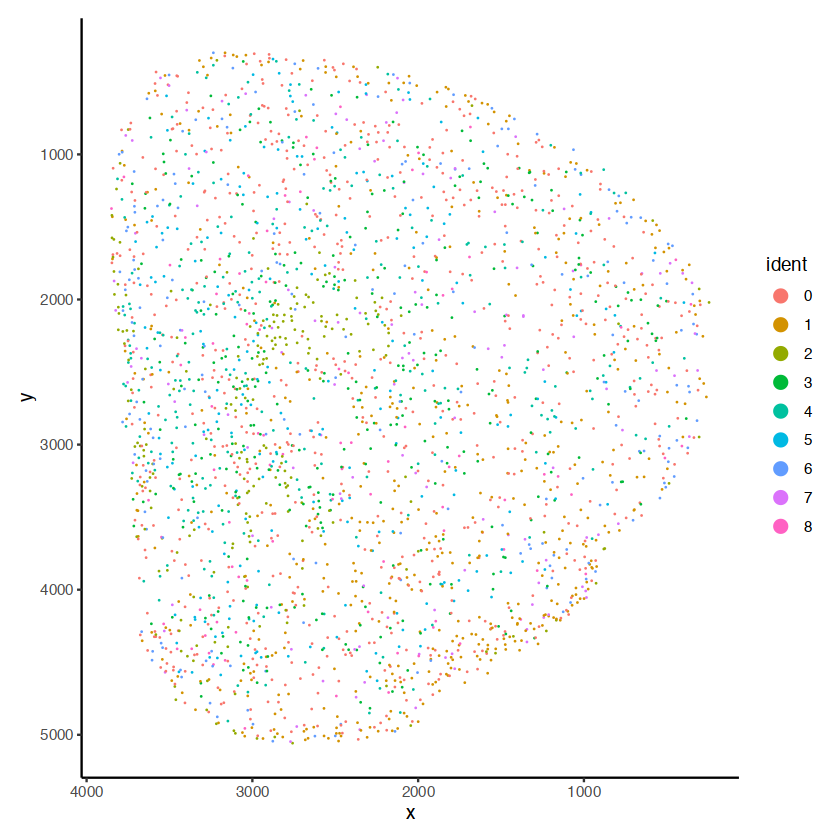

In [16]:
ImageDimPlot(AS,fov = "Region_1_full.2",flip_xy = TRUE) +theme_classic()+scale_y_reverse()+scale_x_reverse()
ImageDimPlot(AS,fov = "Region_7_full.2",flip_xy = FALSE) +theme_classic()+scale_y_reverse()
ImageDimPlot(AS,fov = "Region_5_full",flip_xy = FALSE)+theme_classic() +scale_y_reverse() +scale_x_reverse()

# Figure E

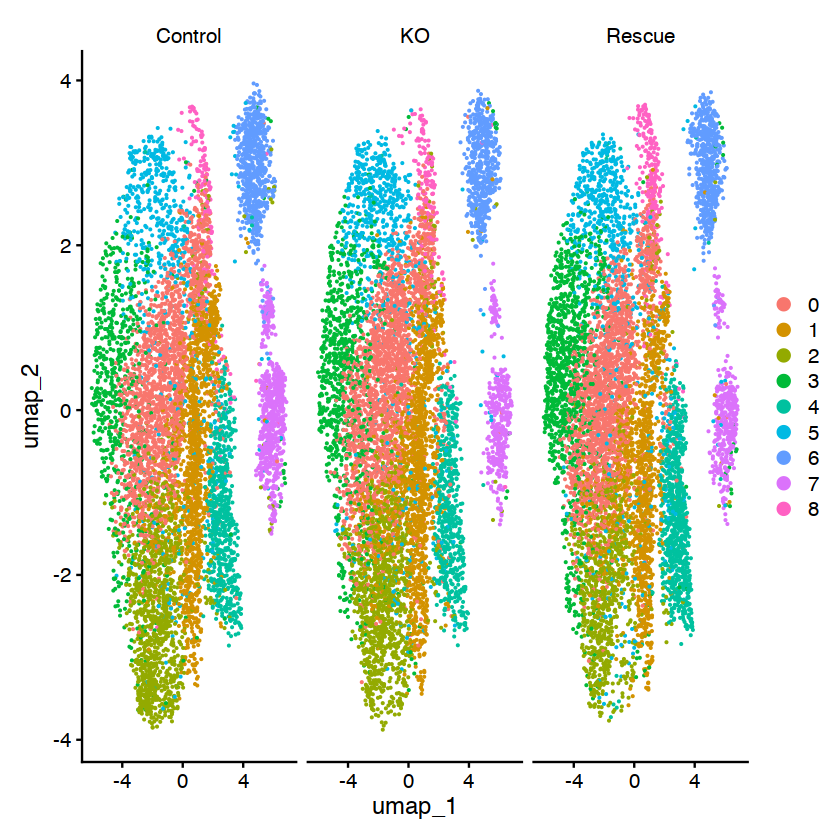

In [18]:
DimPlot(AS,pt.size = 0.1,split.by = "condition",raster = FALSE)

# Figure F

In [20]:
Idents(AS) <- "condition"
AS_group_markers <- FindAllMarkers(AS)
AS_group_markers %>% filter(cluster == "KO" &p_val_adj < 0.05 & avg_log2FC > 0.1) -> up_AS
AS_group_markers %>% filter(cluster == "KO" &p_val_adj < 0.05 & avg_log2FC < -0.1) -> dn_AS

Calculating cluster Control

Calculating cluster KO

Calculating cluster Rescue



Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


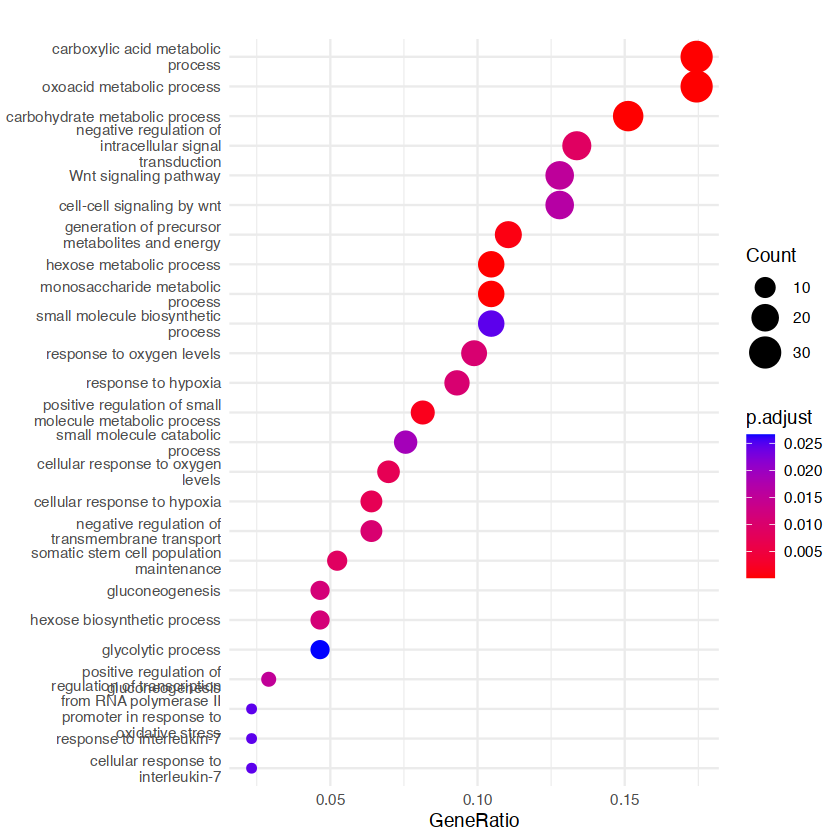

In [21]:
ego_KO <- enrichGO(gene=up_AS$gene, keyType = "SYMBOL",universe=row.names(AS), OrgDb=org.Mm.eg.db, ont="BP", qvalueCutoff=0.05)
ego_KO.simp <- simplify(ego_KO, cutoff=0.7, by="p.adjust", select_fun=min)
dotplot(ego_KO.simp,showCategory = 25)+scale_size_continuous(range=c(2, 8)) +theme_minimal()
 

# GO analysis & gene expression 

Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



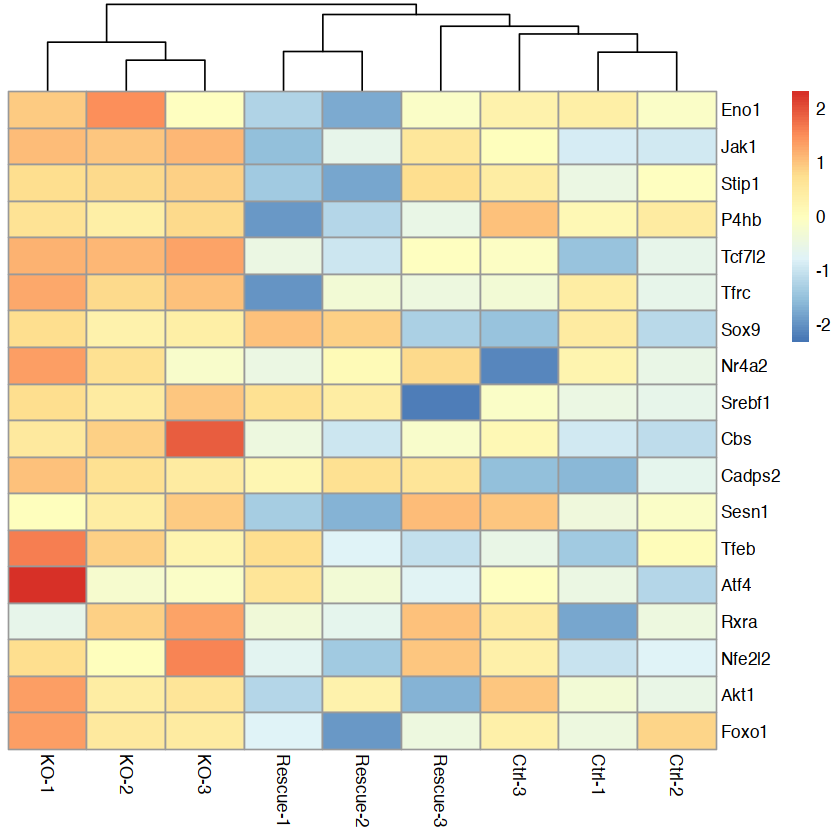

In [24]:
pseudo_AS.df <- AggregateExpression(AS, assays = "Xenium", return.seurat = F, group.by = c("individual"))
metadata_AS <- str_split(colnames(pseudo_AS.df$Xenium), pattern = "-", simplify = TRUE)
row.names(metadata_AS) <- colnames(pseudo_AS.df$Xenium)
colnames(metadata_AS) <- c("condition","replicate")

dds <- DESeqDataSetFromMatrix(countData = round(pseudo_AS.df$Xenium),
                              colData = metadata_AS,
                              design = ~ condition)
dds_lrt <- DESeq(dds, test = "LRT", reduced = ~1)

vsd <- vst(dds_lrt, blind = FALSE)
mat <- assay(vsd)
pheatmap(mat[c("Eno1","Jak1","Stip1","P4hb","Tcf7l2",
                      "Tfrc","Sox9","Nr4a2","Srebf1","Cbs",
                      "Cadps2","Sesn1","Tfeb","Atf4","Rxra",
                      "Nfe2l2","Akt1","Foxo1"), ],
         cluster_rows = FALSE,
         cluster_cols = TRUE,
         scale ="row")


# Excitatory neuron GO analysis (supplemental A,B)

In [28]:
EX <- readRDS("Exicitatory_only.rds")

In [29]:
Idents(EX) <- "condition"

In [31]:
EX_markers_KO_WT <- FindMarkers(EX,`ident.1` = "KO",`ident.2` = "Control",logfc.threshold = 0)
EX_markers_KO_3TC <- FindMarkers(EX,`ident.1` = "KO",`ident.2` = "Rescue",logfc.threshold = 0)

In [33]:
#KOvsWT
EX_markers_KO_WT %>% filter(p_val_adj < 0.05 & avg_log2FC >0 ) %>% row.names() -> KOvsWT_up
EX_markers_KO_WT %>% filter(p_val_adj < 0.05 & avg_log2FC < 0 ) %>% row.names() -> KOvsWT_down
#KOvs3TC
EX_markers_KO_3TC %>% filter(p_val_adj < 0.05 & avg_log2FC >0 ) %>% row.names() -> KOvs3TC_up
EX_markers_KO_3TC %>% filter(p_val_adj < 0.05 & avg_log2FC < 0 ) %>% row.names() -> KOvs3TC_down

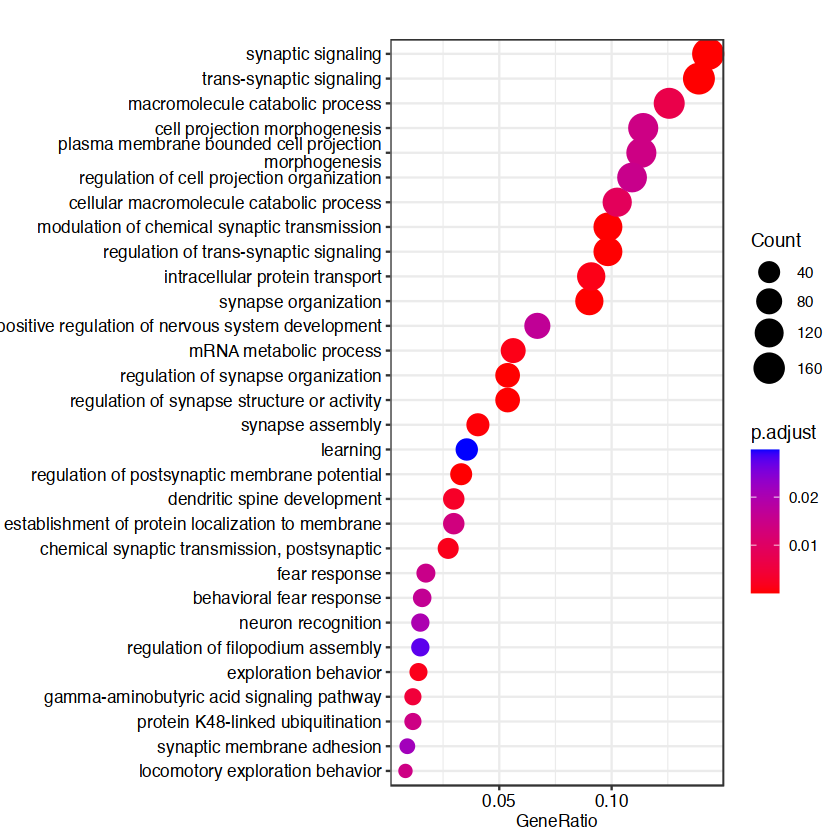

In [34]:
KO_dn_GOvsWT <- enrichGO(gene=KOvsWT_down, keyType = "SYMBOL",universe=row.names(EX), OrgDb=org.Mm.eg.db, ont="BP", qvalueCutoff=0.05)
KO_dn_GOvsWT.sim <- simplify(KO_dn_GOvsWT, cutoff=0.7, by="p.adjust", select_fun=min)
dotplot(KO_dn_GOvsWT.sim,showCategory = 30,font.size = 10,label_format = 50) 

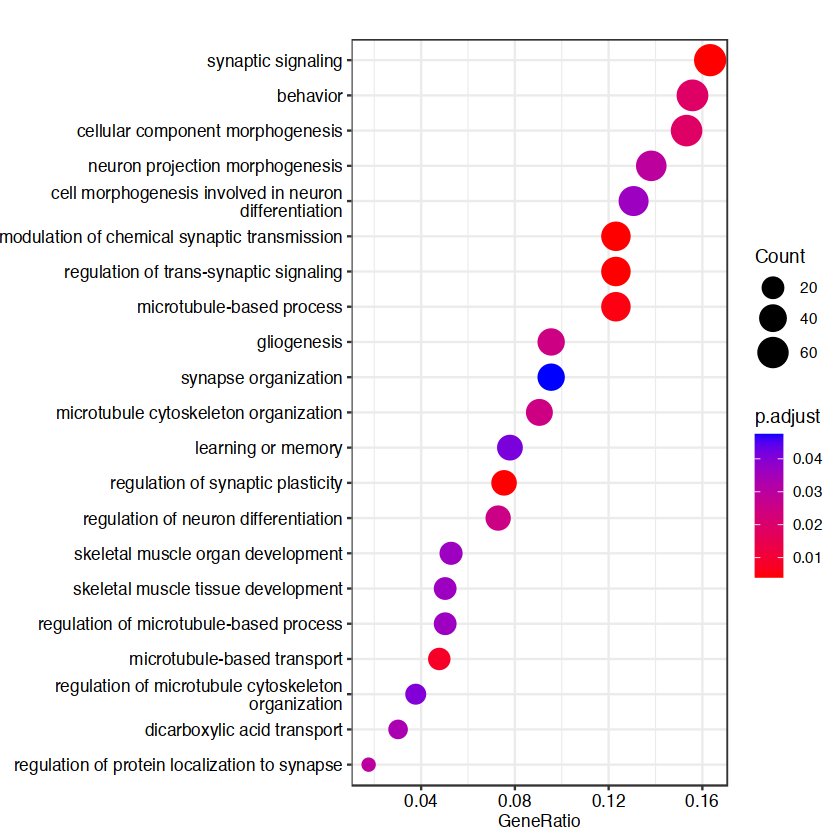

In [39]:
KO_dn_GOvs3TC <- enrichGO(gene=KOvs3TC_down, keyType = "SYMBOL",universe=row.names(EX), OrgDb=org.Mm.eg.db, ont="BP", qvalueCutoff=0.05)
KO_dn_GOvs3TC.sim <- simplify(KO_dn_GOvs3TC, cutoff=0.7, by="p.adjust", select_fun=min)
dotplot(KO_dn_GOvs3TC.sim,showCategory = 30,font.size = 10,label_format = 50) 

# Synaptic signaling related genes expresssion (supplemental C)

In [42]:
Ex_syn_markers <- c("Ppp3r1", "App", "Nptxr","Grm2","Tubb2b","Gucy1a1","Mef2c","Otof",
"Calb1","L1cam","Lrrtm1","Nlgn3","Rac1","Ly6h","Cacna1a","Syn3",
"Ywhag","Cspg5","Cd24a","Gipc1","Gfap","Dagla","Glra1","Prkcz",
"Zzef1","Gria1","Oxtr","Nlgn2")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


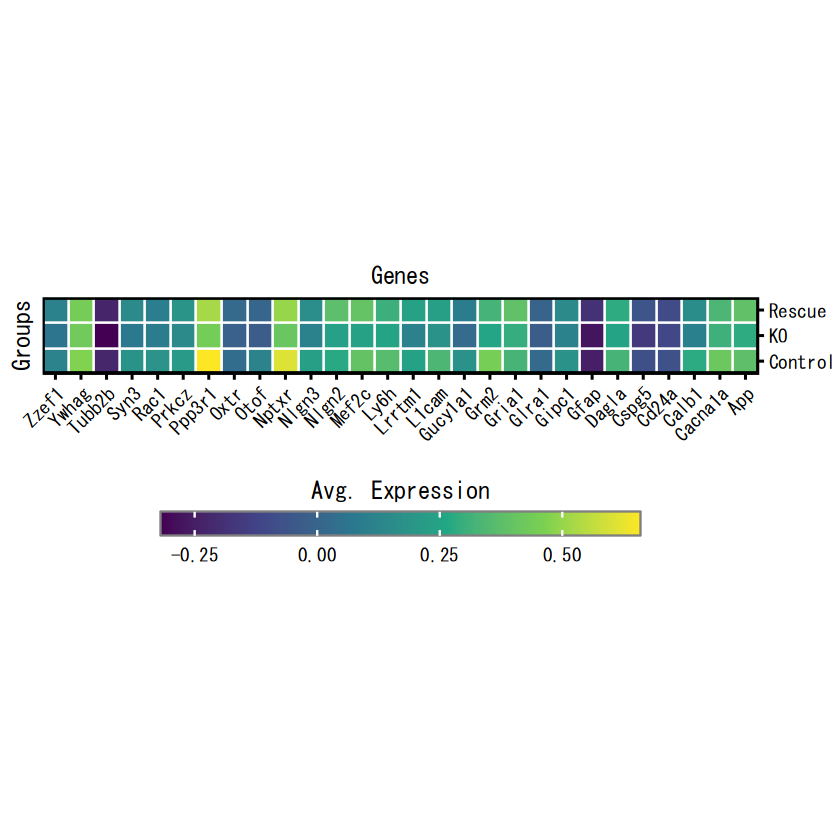

In [43]:
do_ExpressionHeatmap(EX,Ex_syn_markers,slot = "scale",cluster = FALSE,groups.order = c("Control", "KO","Rescue"))+scale_fill_viridis_c()